# Andrew Ng's Machine Learning MOOC: Week 4: Neural Networks

# Programming Exercise 3

## 0. Introduction
This notebook contains my solutions to the programming exercise for week 4 of Andrew Ng's famous Machine Learning MOOC on Coursera (https://www.coursera.org/learn/machine-learning). 

In this exercise, we are asked to implement two different ways to train an algorithm to be able to classify inputs belonging to multiple classes - specifically, the inputs are images of hand-written digits from the famous MSINT data-set developed by Yann LeCun and others. We are asked to develop two different approaches:

- A multi-class logistic regression classifier (using, "one-vs-many" or "one-vs-all" logistic regression); and
- A neural network [actually, in this programming exercise we only complete the "feed-forward" part of the steps to train the neural network - presumably the actually training and back-propogation comes in Week 5].

Now, the course requires submission of programming exercises in either the MATLAB or OCTAVE programming language.

However since:
* I already code in Python for various web development and data science projects, and
* Python is the pre-eminent language currently used in data science and machine learning (and MATLAB and OCTAVE don't seem to be used anywhere near as much)

I decided it would be more valuable to me to use Python to complete the programming exercises.

I was therefore very pleased to find the following source, which has kindly written a set of python scripts to allow one to create Python implementations of the programming exercises for the course, and still submit them for scoring by the MOOC:
https://github.com/dibgerge/ml-coursera-python-assignments

**Thanks very much <i>dibgerge!</i>**


In addition to the course's own lecture materials, I also used a number of other sources to help me solve the programming exercises. These include:
### Other courses I've completed:
* Harvard's Using Python for Research on edX: https://www.edx.org/course/using-python-for-research
* UC San Diego's Python for Data Science, also on edX: https://www.edx.org/course/python-for-data-science-2
* MIT's Introduction to Computational Thinking and Data Science I and II, also on edX: https://www.edx.org/course/introduction-to-computational-thinking-and-data-4
* Imperial College London's Mathematics for Machine Learning I-III on Coursera: https://www.coursera.org/specializations/mathematics-machine-learning

### Books:
* Python Machine Learning by Sebastian Raschka and Vahid Mirjalili: https://sebastianraschka.com/books.html


### Blogs and websites
I found this blog a very useful reference:
* https://www.johnwittenauer.net/machine-learning-exercises-in-python-part-4/

And of course, there's always StackOverflow!

One thing that struck me, looking at all of these different resources, is how many different ways there are to implement basically the same code in python, even using numpy and pandas dataframes! And that's before we think about object-oriented implementations, or using libraries such as scikitlearn.

OK, now that the introduction is complete, let's get started with some imports.
You can find instructions on how to install required libraries in the README file in *dibgerge*'s  [github repository](https://github.com/dibgerge/ml-coursera-python-assignments).

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Pandas - used for dataframes
import pandas as pd

# Plotting library
from matplotlib import pyplot as plt

# Optimization module in scipy
from scipy.optimize import minimize

# NOTE that the image data are supplied in MATLAB "mat" format
# thankfully there's a scipy module that can load data in the
# MATLAB mat datafile format into python
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 Multi-class Classification with One-vs-All Logistic Regression

In this exercise, you will use both logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - e.g. from recognizing postal codes on  envelopes, to recognizing amounts written on bank cheques. Here we will see how the methods we've have learned can be used for this classification task.

In the last exercise, we developed approaches for "standard" and "regularized" logistic regression. In the first part of the exercise, we'll extend our implementation of logistic regression and apply it to one-vs-all classification.

### 1.1 Dataset

Andrew Ng's MOOC provides us with data in `ex3data1.mat` that contains 5000 training examples of handwritten digits (This is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist) handwritten digit dataset). The `.mat` format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. Fortunately, python provides mechanisms to load MATLAB native format using the `loadmat` function within the `scipy.io` module. This function returns a python dictionary with keys containing the variable names within the `.mat` file.

Note that we could also go and get the data ourselves from the MNIST website (linked above). Page 391 of *Raschka and Mirjalili 2nd ed.* has a good explanation of how to download the full (70,000 image) data set and load this ino python.

Our data set, `ex3data1.mat` is a cut-down version of the full data set, containing 5,000 training examples. Each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5,000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

The second part of the training set is a 5,000-dimensional vector `y` that contains labels for the training set. 

We start the exercise by first loading the dataset, below:

In [2]:
# 20x20 Input Images of Digits
input_layer_size  = 400

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

m = y.size

### 1.2 Visualizing the data

Let's start by visualizing a subset of the training set. In the following cell, the code randomly selects selects 100 rows from `X` and passes those rows to the `displayData` function (already written for us by *dibgerge*, and located in the file `utils.py` - do take a look and see how it works!). This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together.

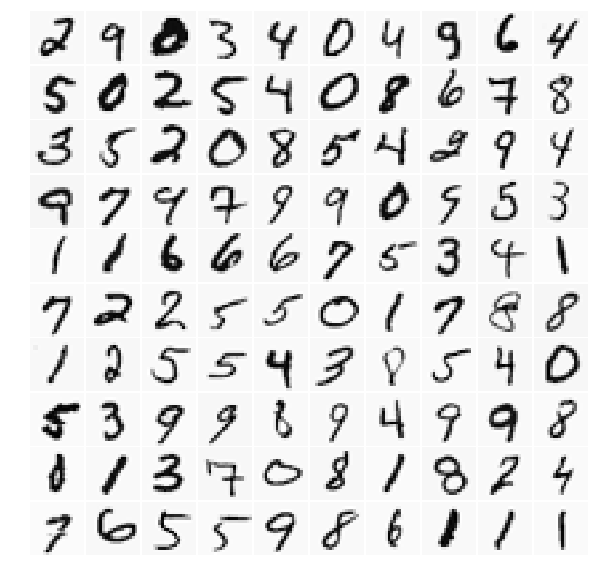

In [3]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

Now let's just display the first 100 items in X, which should all be '0's

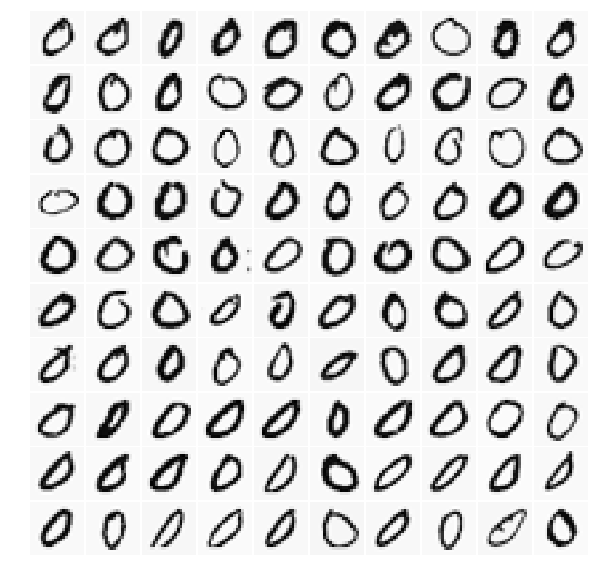

In [4]:
indices = range(100)
selection2 = X[indices, :]
utils.displayData(selection2)

It's worth looking at the data in a little more detail in another way, too.

Let's take a look and see what min and max values are:

In [5]:
print("Min = {}, Max = {}".format(np.amin(X), np.amax(X)))

Min = -0.13196323019852488, Max = 1.127688299158888


It looks to me as though these values have been *standardized* - i.e. converted into *relative* values distributed around the mean, where 0 = the mean value, and +/- 1 represents 1 standard deviation from the mean.

This is a useful bit of pre-processing that has been done for us. The reason it's useful is that we're going to deploy regularized logistic regression, and it only makes sense to deploy this algorithm on *normalized* or *standardized* data - i.e. data that are "*scale-invariant*". Anyway, I digress.

### 1.3 Vectorizing Logistic Regression

Our first task is to implement multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, we will need to train 10 separate logistic regression classifiers.

To make this training efficient, it is important to ensure that your code is well vectorized. In this section, we will implement a vectorized version of logistic regression that does not employ any `for` loops. We will use the code we wrote for last week's binary classification (i.e. two classes) logistic regression as a starting point.

To test your vectorized logistic regression, we will use custom data as defined in the following cell.

In [6]:
# test values for the parameters theta
theta_test = np.array([-2, -1, 1, 2], dtype=float)
print("theta_test's shape is {}".format(theta_test.shape))

# test values for the inputs
X_test = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)
print("X_test's shape is {}".format(X_test.shape))

# test values for the labels
y_test = np.array([1, 0, 1, 0, 1])
print("y_test's shape is {}".format(y_test.shape))

# test value for the regularization parameter
lambda_test = 3

theta_test's shape is (4,)
X_test's shape is (5, 4)
y_test's shape is (5,)


<a id="section1"></a>
#### 1.3.1 Vectorizing the cost function 

We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

To compute each element in the summation, we have to compute $h_\theta(x^{(i)})$ for every example $i$, where $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication.

Let us define $X$ and $\theta$ as

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Then, by computing the matrix product $X\theta$, we have: 

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

In the last equality, we used the fact that $a^Tb = b^Ta$ if $a$ and $b$ are vectors. This allows us to compute the products $\theta^T x^{(i)}$ for all our examples $i$ in one line of code.

#### 1.3.2 Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as

$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$ (this is called the *Jacobean* of J):

$$
\begin{align*}
\begin{bmatrix} 
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

where

$$  h_\theta(x) - y = 
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$

Note that $x^{(i)}$ is a vector, while $h_\theta\left(x^{(i)}\right) - y^{(i)}$  is a scalar (single number).
To understand the last step of the derivation, let $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$ and
observe that:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

where the values $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

The expression above allows us to compute all the partial derivatives without any loops. You may want to work through the matrix multiplications above to convince yourself that the vectorized version does achieve the same computations as the non-vectorized version.

Now, our task is to write the regularized cost function `lrCostFunction` which returns both the cost function $J(\theta)$ and its gradient $\frac{\partial J}{\partial \theta}$. Remember that the cost function for regularized logistic regression is defined as:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_\theta\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_\theta \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that we should **not** be regularizing $\theta_0$, which is used for the bias term.

Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as:

$$
\begin{align*}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_0} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \text{for } j  \ge 1
\end{align*}
$$

We are asked to use the strategy presented above to calculate $\theta^T x^{(i)}$. We should also use a vectorized approach for the rest of the cost function. A fully vectorized version of `lrCostFunction` should not contain any loops.

It's worth taking a moment to revise / get clear what all this is doing.
- The *cost function* $J\theta$ says "Here's a possible solution, theta, for the parameters/weights for our logistic regression function. If we apply this to *X*, how far away is the output from the *actual* output we were looking for?
- The *gradient*, $\frac{\partial J}{\partial \theta}$, tells us how far and in what direction we should change each of those parameters in order to get a slightly better answer than we currently have [and in gradient descent we keep doing this until we're happy with the answer].

By the way, I found the first two parts of Imperial College's "Mathematics for Machine Learning" specialization on Coursera covers the maths behind this very well, and I'd recommend the courses. Khan Academy also covers much of this material and I found it very accessible.

Now, last week we already wrote code to do this. And our code to return the cost function $J(\theta)$ was already completely vectorized (go us!). Our code for the gradient, however, did include a for-loop, so we're going to need to get rid of that here.

In [7]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Computes the cost of using theta as the parameter for regularized
    logistic regression and the gradient of the cost w.r.t. to the parameters.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features *including* any intercept.  
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (including intercept).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.    
    """
    #Initialize some useful values
    m = X.shape[0] # number of training examples
    n = X.shape[1] # number of features *including leading 1s - i.e. the intercept* 
    
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    
    # instantiate initial values of J and grad
    J = 0
    grad = np.zeros(theta.shape)
    
    # calculate the value of J at each step
    net_input = np.dot(X, theta)
    y_hat = utils.sigmoid(net_input)
    J_term1 = -y.dot(np.log(y_hat))
    J_term2 = (1-y).dot(np.log(1-y_hat))
    J_term3 = (lambda_ / (2 * m)) * np.sum(np.power(theta[1:n], 2)) # values of theta *excluding* initial column of 1s
    J = np.sum(J_term1 - J_term2)/m + J_term3
    
    # calculate [the values of] grad at each step - vectorized implementation
    error = y_hat - y
    grad_term1 = np.dot((X.T), error) / m
    grad_term2 = (lambda_ / m)* theta
    grad = grad_term1 + grad_term2
    # then calculate the intercept term (grad[0]) separately
    # ...because it is not regularized
    term = X[:,0].T * error
    grad[0] = np.sum(term) / m
    
    # return J, grad
    return J, grad

In [8]:
J, grad = lrCostFunction(theta_test, X_test, y_test, lambda_test)

print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


**BOOM!**

<a id="section2"></a>
### 1.4 One-vs-all Classification

In the next part of the exercise, we have to implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K = 10$, but the code needs to work for any value of $K$. 

Our code will return all the classifier parameters in a matrix $\theta \in \mathbb{R}^{K \times (N +1)}$, where each row of $\theta$ corresponds to the learned logistic regression parameters for one class. In python, we can train each classifier independently using a “for”-loop in the range($K$) [in which the final value will be $K-1$].

Note that the `y` argument to this function is a vector of labels from 0 to 9. When training the classifier for class $k \in \{0, ..., K-1\}$, we will need to have a K-dimensional vector of labels $y$, where $y_j \in 0, 1$ indicates whether the $j^{th}$ training instance belongs to class $k$ $(y_j = 1)$, or if it belongs to a different
class $(y_j = 0)$.

We will use scipy's `optimize.minimize` to calculate the optimal values of $\theta$ - the docs are [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)
<a id="oneVsAll"></a>

In [9]:
def oneVsAll(X, y, num_labels, lambda_, method='CG'):
    """
    Trains num_labels logistic regression classifiers using the "One-vs-All" method,
    and returns each of these classifiers in a matrix all_theta,
    where the i-th row of all_theta corresponds to the classifier for label i.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of 
        data points, and n is the number of features.
        Note: we assume that the intercept term (or bias term) IS NOT in X
        - we add the intercept a part of the function. 
    
    y : array_like
        The data labels. A vector of shape (m, ).
    
    num_labels : int
        Number of possible labels.
    
    lambda_ : float
        The logistic regularization parameter.
        
    method : keyword argument
        The algorithm selected to minimize theta, used in scipy.optimize.minimize()
    
    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    
    Note
    ----
    By default, as suggested in "dibgerge"'s notes to this notebook,
    this function uses `scipy.optimize.minimize(method='CG')` to optimize
    the cost function. This is the "conjugate gradient" algorithm.
    Other methods are available as part of optimize.minimize().
    This can be changed by passing in a different value of the 'method'
    parameter when calling the function.
    """
    # Define some useful variables
    m, n = X.shape
    
    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # Instantiate initial matrix "all_theta", filled with 0s
    all_theta = np.zeros((num_labels, n + 1))
    
    # Loop over each label (defined in num_labels) 
    for number in range(num_labels):
        # initialize an n-item vector to hold the theta values for this label
        theta = np.zeros(n + 1)
        # set up an m-dimensional vector is "True" [i.e. == 1] y is the same as number, 0 otherwise
        # (using list-comprehension and boolean mask)
        y_number = np.array([1 if label == number else 0 for label in y])
    
        # Set options for minimize
        options = {'maxiter': 50}
    
        # Run minimize to obtain the optimal theta for this sub-set (i.e. data-points with label [number]).
        # This function will return a class object where theta is in `res.x` and cost in `res.fun`
        result = minimize(fun=lrCostFunction, x0=theta, args=(X, y_number, lambda_), method=method, jac=True)
         
        # Add the optimized value of theta to the [number]th row of all_theta
        all_theta[number,:] = result.x
        
    return all_theta

#### 1.4.1 Training our Classifier

Now we can use our `oneVsAll()` function to train a multi-class classifier:

In [10]:
lambda_ = 0.1
num_labels = 10
all_theta = oneVsAll(X, y, num_labels, lambda_)

<a id="section3"></a>
#### 1.4.2 One-vs-all Prediction

After training our one-vs-all classifier, we can now use it to predict the digit contained in a given image.

For any input, our aim is to compute the “probability” that it belongs to each class, using the trained logistic regression classifiers. Our one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (0, 1, ..., K-1) as the prediction for the input example.

We achieve this using a function `predictOneVsAll()` to use our newly-trained one-vs-all classifier to make predictions. 
<a id="predictOneVsAll"></a>

In [11]:
def predictOneVsAll(all_theta, X):
    """
    Return a vector of predictions for each example in the matrix X. 
    Note that X contains the examples in rows. all_theta is a matrix where
    the i-th row is a trained logistic regression theta vector for the 
    i-th class. 
    
    You should set p to a vector of values from 0..K-1 
    (e.g., p = [0, 2, 0, 1] predicts classes 0, 2, 0, 1 for 4 examples) .
    
    Parameters
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features *excluding* the bias / intercept term.
    
    X : array_like
        Data points for which we want to predict their labels.
        This is a matrix of shape (m x n) where m is number of data points to predict,
        and n is the number of features *without* the bias term.
        Note we add the bias term for X in this function. 
    
    Returns
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned logistic
    regression parameters (one-vs-all). You should set p to a vector of predictions
    (from 0 to num_labels-1).
    
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index 
    of the max for each row.
    """
    # Define some useful variables
    m = X.shape[0]
    n = X.shape[1]
    num_labels = all_theta.shape[0]

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    # Instantiate an initial output vector, filling it with 0s
    p = np.zeros(m)

    # compute the class probability for each class on each training instance
    # using our sigmoid() function
    h = utils.sigmoid(np.dot(X, all_theta.T)) # note - worth checking the dimensions of X and
                                              # all_theta to make sure they're correct
    print("h's shape is {}".format(h.shape))
    # create an array of the index with the maximum probability
    p = np.argmax(h, axis=1)

    return p

We can now call our `predictOneVsAll()` function using the previously learned value of $\theta$.
The specifications say that we should see that the training set accuracy is about 95.1% (i.e., it classifies 95.1% of the examples in the training set correctly).

In [12]:
y_hat = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(y_hat == y) * 100))

h's shape is (5000, 10)
Training Set Accuracy: 90.32%


Well, this is a little low. Disappointing. Let's run through some different values of `lambda_` to see if we can improve our accuracy:

In [13]:
lambdas = [0.01, 0.1, 0.5, 1]
for lambda_ in lambdas:
    all_theta = oneVsAll(X, y, num_labels, lambda_)
    y_hat = predictOneVsAll(all_theta, X)
    print('Training Set Accuracy with lambda = {}: {:.2f}%'.format(lambda_, (np.mean(y_hat == y) * 100)))

h's shape is (5000, 10)
Training Set Accuracy with lambda = 0.01: 92.74%
h's shape is (5000, 10)
Training Set Accuracy with lambda = 0.1: 90.32%
h's shape is (5000, 10)
Training Set Accuracy with lambda = 0.5: 87.72%
h's shape is (5000, 10)
Training Set Accuracy with lambda = 1: 86.78%


To be honest, this isn't as good as I'd expected. I'm going to see if we can get a better result using a different minimization method from `scipy`'s `optimize.minimize()` method in `oneVsAll()`

In [14]:
all_theta = oneVsAll(X, y, num_labels, lambda_=0.05, method="TNC")
y_hat = predictOneVsAll(all_theta, X)
print('Training Set Accuracy with lambda = {}: {:.2f}%'.format(lambda_, (np.mean(y_hat == y) * 100)))

h's shape is (5000, 10)
Training Set Accuracy with lambda = 1: 96.76%


This is much better - and closer to what I was expecting.

It's also interesting to see how much difference choosing a different optimization algorithm makes to the resulting accuracy - it would also be interesting to know whether the algorithms do better / worse in terms of under- or over-fitting the algorithm to the data.

## 2 Neural Networks

In section 1 (above), we implemented multi-class logistic regression to recognize handwritten digits. However, "standard" logistic regression cannot form more complex hypotheses as it is only a linear classifier. Now, we could add more features - such as polynomial features - to logistic regression to enable us to find a higher-dimensional hyperplan that can be separated. However, this can be can be very expensive to train; and may also be at greater risk of over-fitting.

In this part of the exercise, we develop an alternative approach - we will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. In this week's, we will use parameters (also known as "weights") from a neural network that Andrew Ng's course has already provided. Our task is to implement the feed-forward propagation algorithm to use these weights for prediction.

In next week’s exercise, we will write the backpropagation algorithm for learning the neural network parameters.

To begin, we re-load and visualize dataset which contains the MNIST handwritten digits (this is the same as we did in the first part of this exercise, we reload it here to ensure the variables have not been modified). 

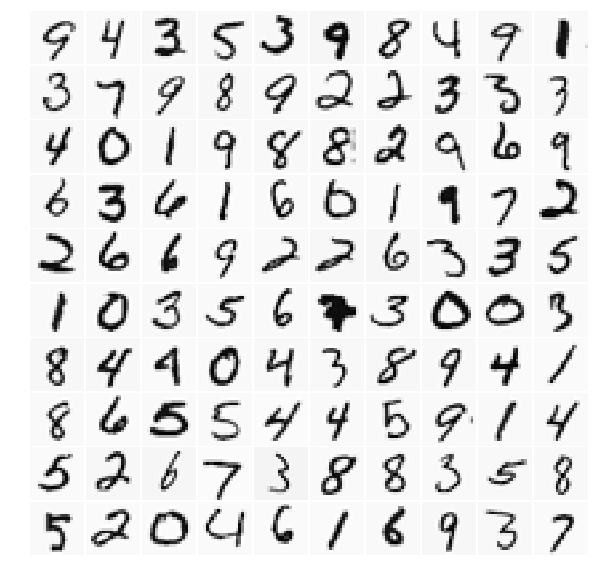

In [15]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# get number of examples in dataset
m = y.size

# randomly permute examples, to be used for visualizing one 
# picture at a time
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)


### 2.1 Model representation 

Our neural network is shown in the following figure.

![Neural network](Figures/neuralnetwork.png)

The network has 3 layers: an input layer, a hidden layer and an output layer. The inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units - each unit representing one of the pixels in the input data (excluding the extra bias unit which always outputs +1). We've already loaded the training data into the variables X and y. 

In this part of the exercise, we have to implement the code for the "feed-forward" propogation of the data through the neural network. To do this, we need to have a set of network parameters - often called *weights* for all of the links in the network. At this stage, the course provides us with these, in two matrices ($\Theta^{(1)}$, $\Theta^{(2)}$), which have already been "trained" by the course - i.e. the course has already optimized these weights to give a "good" performance in matching the inputs to the desired outputs. [In the next exercise, we will implement the back-propopgation algorithm to "train" the network ourselves].

The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

These $\Theta$ parameters are stored in `ex3weights.mat`. We load them using the useful `loadmat()` function which takes input set up for use with MATLAB, and loads it into Python for us. The following cell loads those parameters into  `Theta1` and `Theta2`.

In [16]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary 
weights = loadmat(os.path.join('Data', 'ex3weights.mat'))

# get the model weights from the dictionary
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

<a id="section4"></a>
### 2.2 Feedforward Propagation and Prediction

Now we've loaded our data, we need to implement feedforward propagation for the neural network. To do this, our task is to write/complete the function `predict`, which will to return the neural network’s prediction. Specifically, we need to implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $\left( h_\theta(x) \right)_k$.

Now, here's where implementation gets interesting. First of all, let's look at the shapes of our different data:

In [17]:
X.shape, y.shape, Theta1.shape, Theta2.shape

((5000, 400), (5000,), (25, 401), (10, 26))

So, what are we seeing?
- Well, $X$ is a [5000 x 400] matrix, representing 5,000 examples, each with 400 "features" - i.e. 5,000 different images of hand-written numbers, each with a value representing each of 400 pixels that make up the image. Every unit in the input represents a single pixel.
- $y$ is a [5000-row] vector, representing the number that each image represents (from 0 to 9) - we can think of this as the "target output".
- $\Theta^1$ is a [25 x 401] matrix, with each row representing a unit in our hidden layer, and each column representing the weights for the connection between each of the 400 pixels in our input layer, and the 25 units in the hidden layer.
-  $\Theta^2$ is a [10 x 26] matrix, with each row representing a unit in our output layer, and each column representing the weights for the connection between each of the 25 hidden layer units and the 10 units in the output layer.

***Wait, what?***

If $\Theta^1$ represents the weights of the connections between 400 input units, and 25 hidden layer units, how come its dimensions are [25 x **401**]?

And if $\Theta^2$ representes the weights of the connections between 25 hidden layer units and 10 output layer units, how come *its* dimensions are [10 X **26**]?

Well, this comes down to a - *difference of opinion*? - in how to represent neural networks.

All neural networks are built with a "bias unit" in each layer. Now, in this course, it seems we are to represent the bias unit as:
- An additional column [of 1s] in the input data [the "bias unit" always outputs 1]
- An additional column of weights between each layer - with the final column of weights acting on the bias unit.

However, other sources (e.g. Imperial's *Mathematics for Machine Learning* (course)[https://www.coursera.org/specializations/mathematics-machine-learning]) represent things differently. Imagine a really simple neural network with only two nodes. They represent the *net input* from the node in layer 0 to the node in layer 1 as:

$$a^1 = w^0.a^0 + b$$

The output (or "activity") of $a^1$ is then

$$\sigma(a^1)$$which is to say $$\sigma(w_0.a_0 + b)$$

If we add a second node to the layer0, we get

$$a^1 = \sigma(w_0.a_0^0 + b) + \sigma(w_1.a_1^0 + b)$$

Re-arranging, we get:

$$a^1 = \sigma(w_0.a_0^0 + w_1.a_1^0+ b)$$

Which is to say:

$$a^1 = \sigma(W^1.a^0 + b^1)$$

where:
- $W^1$ is the matrix of weights between units in layer 0 to units layer 1
- $a^0$ is the vector of inputs coming out of layer 0
- $b^1$ is the vector of biases for the inputs into each unit in layer 1 [**Note** the biases are the same for each unit in layer 1]

Next week, when I create an object-oriented implementation of this neural network, following the approach set out in *Raschka and Mirjalili*, we'll see that they follow this approach, too.

Personally, I like this approach to representing neural networks, because:
- The dimensions of each layer matches the dimensions of the layer preceeding it (e.g. our inputs are 400-columns wide; so I'd expect our weights to also be 400-columns wide...not 401). This means we don't need to add a column of 1s to our data before using it.
- We can pull out the biases and weights into separate matrices/vectors and adjust them separately.

Looking back at the way our data is represented, we can see that the course has added an additional column of weights to both sets of connections (i.e. between the input layer and the hidden layer; and between the hidden layer and the output layer). The approach suggested by the course is for us to add a column of 1s to our input data to represent the (output of the) bias units.

Instead, I'd like to try representing the bias units as a set of vectors, which means that instead of adding a column of 1s to the input data, I'm going to *strip out* a column from each of the weights matrices (i.e. $\Theta$ 1 and 2) and having them represent the biases. Now, in order to do this, I need to know: *which column in the weights represents the biases (i.e. which are set-up to act on the bias units?*).

To be honest, it's not clear from the documentation for the exercise - but it can only be in one of two places - either the first or the last column. The notes suggest it's going to be the last column, so let's assume that, and go from there.

In [18]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network with three layers:
    - Input
    - Hidden layer
    - Output layer
    
    Parameters
    ----------
    Theta1 : array_like
        Weights between the input layer and the hidden layer in the neural network.
        It has shape (hidden layer size x input size)
    
    Theta2: array_like
        Weights between the hidden layer and the output layer. 
        It has shape (output layer size x hidden layer size)
    
    X : array_like
        The image inputs having shape (number of examples x image dimensions).
    
    Return 
    ------
    y_hat : array_like
        A vector containing the predicted label for each example.
        It has a length equal to the number of examples.
     
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the  max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index
    of the max for each row.
    
    Note
    ----
    We use the `sigmoid()` function supplied in `utils.py`. 
    We call this using `utils.sigmoid(z)`, where `z` is the required
    input variable to sigmoid.
    """
    # make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    
    # define some useful variables
    num_examples = X.shape[0]
    num_labels = Theta2.shape[0]

    # instantiate our output vector
    y_hat = np.zeros(X.shape[0])

    # strip out our bias vectors from Theta1 and Theta2
    Theta1_new, b1 = Theta1[:, :-1], Theta1[:, -1]
    Theta2_new, b2 = Theta2[:, :-1], Theta2[:, -1]

    # useful to look at the shapes of each of our matrices and vectors
    # to make sure they are appropriate and help de-bug
#     print("Shapes:")
#     print("X: {}".format(X.shape))
#     print("Theta1: {}".format(Theta1.shape))
#     print("Theta1_new: {}".format(Theta1_new.shape))
#     print("b1{}".format(b1.shape))
#     print("Theta2: {}".format(Theta2.shape))
#     print("Theta2_new: {}".format(Theta2_new.shape))
#     print("b2: {}".format(b2.shape))
    
    
    # step 1 - calculate net input of hidden layer
    z_hidden = np.dot(X, Theta1_new.T) + b1
    # step 2 - calculate activation of hidden layer
    a_hidden = utils.sigmoid(z_hidden)
    
    # step 3 - calculate net input of output layer
    z_output = np.dot(a_hidden, Theta2_new.T) + b2
    
    # step 4 - calculate activation of output layer
    a_output = utils.sigmoid(z_output)
    
    # step 5 - calculate MAX activation of output layer
    # create an array of the index with the maximum probability
    # representing highest probability output class    
#     print("a_output's shape is {}".format(a_output.shape))
    y_hat = np.argmax(a_output, axis=1)
#     print("y_hat's shape is {}".format(y_hat.shape))
    return y_hat

OK, now let's call our `predict()` function using the loaded set of parameters for `Theta1` and `Theta2`. We're told that we should see that an accuracy of about 97.5%.

In [19]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 17.5%


OK - that's not very good!

Let's try again and see if the bias vectors are in fact encoded in column [0] of $\Theta$ 1 and 2

In [1]:
def predict2(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network with three layers:
    - Input
    - Hidden layer
    - Output layer
    
    Parameters
    ----------
    Theta1 : array_like
        Weights between the input layer and the hidden layer in the neural network.
        It has shape (hidden layer size x input size)
    
    Theta2: array_like
        Weights between the hidden layer and the output layer. 
        It has shape (output layer size x hidden layer size)
    
    X : array_like
        The image inputs having shape (number of examples x image dimensions).
    
    Return 
    ------
    y_hat : array_like
        A vector containing the predicted label for each example.
        It has a length equal to the number of examples.
     
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the  max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index
    of the max for each row.
    
    Note
    ----
    We use the `sigmoid()` function supplied in `utils.py`. 
    We call this using `utils.sigmoid(z)`, where `z` is the required
    input variable to sigmoid.
    """
    # make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    
    # define some useful variables
    num_examples = X.shape[0]
    num_labels = Theta2.shape[0]

    # instantiate our output vector
    y_hat = np.zeros(X.shape[0])

    # strip out our bias vectors from Theta1 and Theta2
    Theta1_new, b1 = Theta1[:, 1:], Theta1[:, 0:1]
    Theta2_new, b2 = Theta2[:, 1:], Theta2[:, 0:1]
    # turn b1 and b2 into vectors (rather than n x 1 matrices)
    b1 = b1.ravel() 
    b2 = b2.ravel()
    
    # step 1 - calculate net input of hidden layer
    z_hidden = np.dot(X, Theta1_new.T) + b1
    
    # step 2 - calculate activation of hidden layer
    a_hidden = utils.sigmoid(z_hidden)
    
    # step 3 - calculate net input of output layer
    z_output = np.dot(a_hidden, Theta2_new.T) + b2
    
    # step 4 - calculate activation of output layer
    a_output = utils.sigmoid(z_output)
    
    # step 5 - calculate MAX activation of output layer
    # create an array of the index with the maximum probability
    # representing highest probability output class    
    y_hat = np.argmax(a_output, axis=1)
    return y_hat

In [21]:
pred = predict2(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 97.5%


**That's more like it!**

Now *dibgerge* has helpfully provided some neat code that displays images from the training set one at a time, while at the same time printing out label our neural network predicts for the displayed image. 

Run the following cell to display a single image the the neural network's prediction. You can run the cell multiple time to see predictions for different images.

Neural Network Prediction: 9


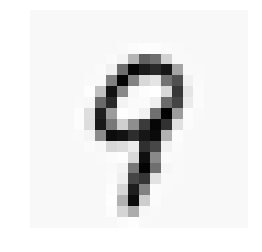

In [25]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    utils.displayData(X[i, :], figsize=(4, 4))
    pred = predict2(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')

### 3 Summary and Next Steps

So, that's the programming exercise for Week 4 of Stanford / Andrew Ng's *Machine Learning* course on Coursera (programming exercise 3) complete.

What did we do and learn?

- We wrote an algorithm to implement *regularized* one-vs-all logistic regression.
- We then used scipy's `optimize.minimize()` method to classify [data representing] hand-written digits using our algorithm - with an accuracy of ~97%.
- Next we wrote code to implement a relatively simple three-layer neural network to perform the same task (i.e. classify hand-written digits - achieving an accuracy of 97.5%
- However, we *kind-of* cheated with our neural network - we used weights ($\Theta$ parameters) that had *already been trained* (i.e. optimized) in our neural network, rather than training them ourselves. More specifically, we implemented the *feed-forward propogation* algorithm for our neural network, and then applied pre-trained weights to that algorithm to generate an output.

In terms of **Next Steps**, the obvious one is to implement the *back-propogation* algorithm that will allow us to "train" the neural network ourselves - i.e. to find for ourselves the set of weights and biases that minimize errors. Luckily, that's the subject of Week 5's lectures and programming exercise 4! Personally, I'm interested to see whether we will use gradient descent, or some other algorithm, to implement back-propogation.
